In [1]:
# For symbolic calculations
import sympy as sp
# For numeric calculations
import numpy as np

# For plotting
import matplotlib.pyplot as plt

from inflationpy import SlowRollModel, SlowRollEndSolver, SlowRollStartSolver, ModelCompare

# Notebook for calculating observables

For general scalar-tensor field theory during inflation we can write action in form

\begin{equation}
    S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} A(\phi)R  -\frac{1}{2}B(\phi)g^{\mu \nu} \nabla_{\mu} \phi \nabla_{\nu} \phi -  V(\phi)  \right \}
\end{equation} 

When using invariants action can be expressed as

\begin{equation}
    S = \int d^4x \sqrt{-g} \left\{ \frac{M_p^2}{2} R  -\frac{1}{2}g^{\mu \nu} \nabla_{\mu} I_\phi \nabla_{\nu} I_\phi -  I_V(I_\phi)  \right \}
\end{equation} 

This notebook shows how to use this package to compare if model defined with $A$, $B$, $V$ functions predicts the same values as model defined by $I_V$ function.

## 1) Define model functions

To start calculating, required symbols must be defined. By default SlowRollModel assumes that 'phi' is used as scalar field ('I_phi' for invariant field) symbol and 'M_p' as Planck's mass. If other symbols are used then this information must be given to the SlowRollModel class.

To define symbols and equations it is advised to use sympy although it can try to convert strings to equations as well this method is not too reliable. To look more how to define functions with sympy: https://docs.sympy.org/latest/modules/functions/index.html#contents

Currently used model must predict same observable values. As $A=1$ it does not matter if Palatini or metric formalism is used.

In [2]:
# Define symbols. phi for scalar field and I_phi for invariant scalar field.
phi, I_phi = sp.symbols('phi I_phi', real=True)
# Define model specific free parameters and Planck's mass
alpha, M_p = sp.symbols('alpha M_p', real=True, positive=True)
# Also program uses some default symbols: 'N' for e-folds
N = sp.symbols('N', real=True, positive=True)

In [3]:
# Define functions. 
A = 1
B = 6*alpha/(phi/M_p-1)**2
V = (phi/M_p - 2)**2 * (phi/M_p)**2/((phi/M_p)**2 - 2*phi/M_p + 2)**2
I_V = sp.tanh(I_phi/(sp.sqrt(6*alpha)*M_p))**2

model = SlowRollModel(A, B, V, I_V, palatini=False)

# 2) Model comparer

Create model comparer

In [4]:
comparer = ModelCompare(model)

## 2.1) Compare invariant potential $I_V$

This method uses idea that $I_V(\phi) = \frac{V(\phi)}{A^2(\phi)}$ must be equal to $I_V[I_\phi(\phi)]$ where $I_\phi = \int \sqrt{\frac{B(\phi)}{A(\phi)} + \frac{3M_p^2}{2} \left(\frac{A'(\phi)}{A(\phi)}\right)^2 } \text{d}\phi$. If this turns out to be true, then two models predict same results.

Calculating $\frac{V}{A^2}$ is easy and when calculating then prgoram does it automatically. Thus function $I_\phi(\phi)$ must be found. Currenlty we have to do it numerically. First we have to setup the initial condition (integration constant). Let's choose the point at the end of inflation.

In [5]:
# Solver end value for scalar field
solver1 = SlowRollEndSolver(model)
end_value1 = solver1.nsolve_np([0, 2], params={M_p:1, alpha:2})[0]
# Solver end value for invariant scalar field
solver2 = SlowRollEndSolver(model, invariant=True)
end_value2 = solver2.nsolve_np([0, 2], params={M_p:1, alpha:2})[0]

# To use mpmath call function .nsolve_field_mp
# x=[initial_condition_field, calculate_up_to_value], y0=initial_condition for invariant field
invariant_field = comparer.nsolve_field_np(x=[end_value1, 0.99], y0=end_value2, sc_kwargs={'atol':1e-9, 'rtol':1e-9}, params={alpha:2, M_p:1})

Now we can calculate and compare invariant potential values for scalar field values from end_value to 0.99.

In [6]:
# First returned values are calculate by V/A^2. Second reutrned value is through substituion.
potential1, potential2 = comparer.compare_invariant_potential_np(x=np.linspace(end_value1, 0.99), invariant_scalar_field=invariant_field, params={alpha:2, M_p:1})

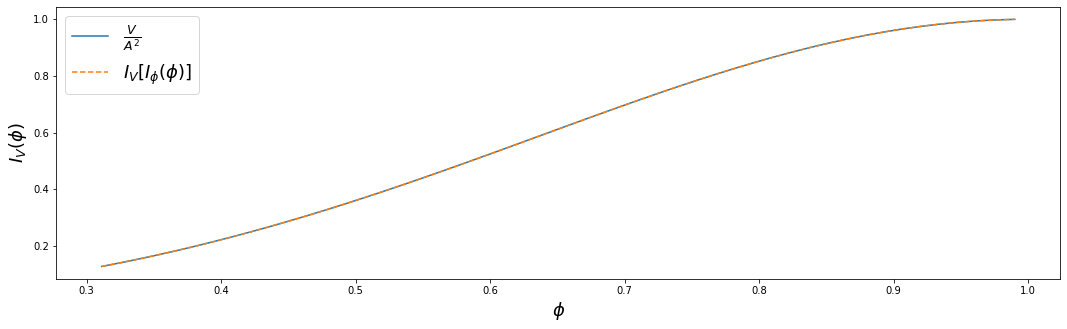

In [7]:
plt.figure(figsize=(18, 5))
plt.plot(np.linspace(end_value1, 0.99), potential1, label='$\\frac{V}{A^2}$')
plt.plot(np.linspace(end_value1, 0.99), potential2, label='$I_V[I_\\phi(\\phi)]$', linestyle='--')
plt.xlabel("$\\phi$", fontsize=18)
plt.ylabel("$I_V(\\phi)$", fontsize=18)
plt.legend(fontsize=18)

## 2.2) Compare invariant scalar field $I_\phi$

This method uses idea that $I_\phi(\phi) = \int \sqrt{\frac{B(\phi)}{A(\phi)} + \frac{3M_p^2}{2} \left(\frac{A'(\phi)}{A(\phi)}\right)^2 } \text{d}\phi$ must be equal to $I_\phi[I_V(\phi)]$. If this turns out to be true, then two models predict same results.

We already have calculated $I_\phi(\phi)$. Now we must find invariant potential inverse function. Currently this method can be used only if analytically inverse function can be found.

In [8]:
inverse_potential = comparer.solve_I_V_inverse()
# Compare in range end_value to 0.99. Select second solution for inverse potential (there are two solutions). 
# First returned values are calculate by invariant potential method. Second reutrned value is through integral.
field1, field2 = comparer.compare_invariant_field_np(
    x=np.linspace(end_value1, 0.99, 1000),
    inverse_invariant_potential=inverse_potential[1],
    invariant_scalar_field=invariant_field,
    params={alpha:2, M_p:1})

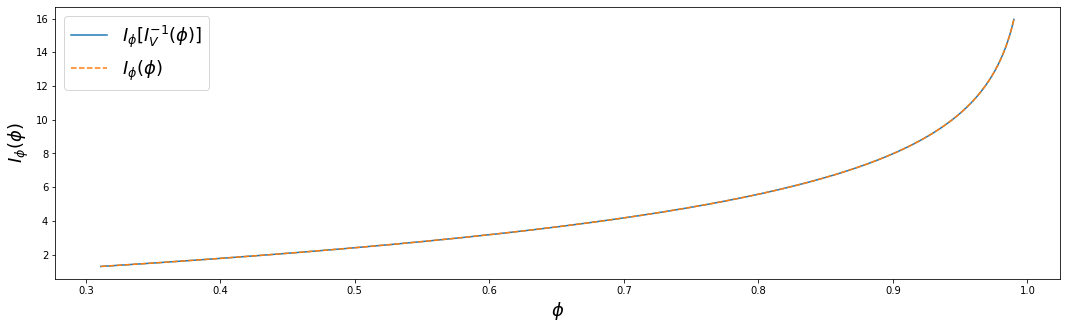

In [9]:
plt.figure(figsize=(18, 5))
plt.plot(np.linspace(end_value1, 0.99, 1000), field1, label='$I_\\phi[I_V^{-1}(\\phi)]$')
plt.plot(np.linspace(end_value1, 0.99, 1000), field2, label='$I_\\phi(\\phi)$', linestyle='--')
plt.xlabel("$\\phi$", fontsize=18)
plt.ylabel("$I_\\phi(\\phi)$", fontsize=18)
plt.legend(fontsize=18)

## 2.3) Compare invariant scalar field derivartive $\frac{\text{d} I_\phi}{\phi}$

Third method is to compare invariant field derivative with scalar field. This is simpler method than comparing scalar field.
This method does not show that two models are identical, meaning that integral $I_\phi(\phi)$ can be different by some constant value (different integration constant). But this will show that predictions are same.

This requires to find invariant potential inverse function (like it was done when comparing invariant scalar fields). The other term is invariant sacalar field definition integrand
$$\sqrt{\frac{B(\phi)}{A(\phi)} + \frac{3M_p^2}{2} \left(\frac{A'(\phi)}{A(\phi)}\right)^2 }$$



In [10]:
# First returned values are calculate by invariant potential method. Second reutrned value is through integrand.
field_der1, field_der2 = comparer.compare_invariant_field_der_np(
    x=np.linspace(end_value1, 0.99, 1000),
    inverse_invariant_potential=inverse_potential[1],
    params={alpha:2, M_p:1})

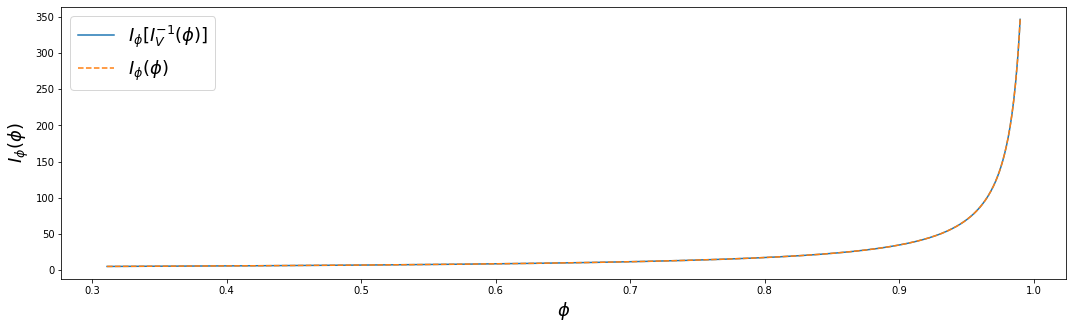

In [11]:
plt.figure(figsize=(18, 5))
plt.plot(np.linspace(end_value1, 0.99, 1000), field_der1, label='$I_\\phi[I_V^{-1}(\\phi)]$')
plt.plot(np.linspace(end_value1, 0.99, 1000), field_der2, label='$I_\\phi(\\phi)$', linestyle='--')
plt.xlabel("$\\phi$", fontsize=18)
plt.ylabel("$I_\\phi(\\phi)$", fontsize=18)
plt.legend(fontsize=18)

# 3) Conclusion

As we can see, all three methods showed that for scalar field values from end of inflation up to scalar field value 0.99 these models predict same invariants. This also means that invariant model and $A$, $B$, $V$ model are same.